In [1]:
from PIL import Image                              # (pip install Pillow)
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import json

from skimage.morphology import skeletonize, medial_axis
from label_centerlines import get_centerline
from skimage import img_as_bool

# temp

In [39]:
# [TODO] 얻어낸 island 에서 IoU 기반으로한 patches 를 얻는 연산 필요 
def no_lines(sub_mask, color_image, img_width, img_height, 
                               filter_ratio=0.03, init_buffer=0):
    """Creates patches of semantic areas.

    Args:
      sub_mask: A sub mask image.
      color_image: A color image.
      img_width: .
      img_height: .
      filter_ratio: 
      init_buffer:

    Returns:
      .: .

    Raises:
      .: .
    """
                
#     img_width = sub_mask.width
#     img_height = sub_mask.height
#     print(img_width, img_height)
    image_area = img_width * img_height
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')
    
    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    patches = []
    fig = plt.figure()
    fig.set_size_inches(12, 27)
    for i, polygon in enumerate(multi_poly):
        area = polygon.area 
        ratio = area / image_area
        if ratio > filter_ratio : 
            buffered_polygons = create_multi_polygons(polygon, init_buffer, image_area)
            centroids = []
            for polyg in buffered_polygons:
                polyg = polyg.simplify(0.1, preserve_topology=False)
                if polyg.area == 0.0:
                    continue
                centroids.append(polyg.centroid.xy)
                drawPolygon(polyg, color_image)
            positions = []
            for ii in centroids:
                positions.append([ii[0][0], ii[1][0]])

#             lines = []
#             if (len(positions) > 1) : 
#                 for i in range(len(positions)):
#                     if i == 0:
#                         vector = []
#                         for j in range(2):
#                             vector.append(positions[i][j] - positions[i+1][j])
                        
#                         d = (vector[1] / vector[0]) * (-positions[0][0]) + positions[0][1]
#                         c = (vector[0] / vector[1]) * (-positions[0][1]) + positions[0][0]
                        
#                         result = []
#                         if abs(d) >= abs(c):
#                             result.append(c)
#                             result.append(0)
#                         else:
#                             result.append(0)
#                             result.append(d)
#                         la = LineString([result, positions[i]])
#                         lines.append(la)
#                         x,y = la.xy
#                         plt.plot(x,y, linewidth=1)

#                     elif i == len(positions)-1:
#                         vector = []
#                         for j in range(2):
#                             vector.append(positions[i][j] - positions[i-1][j])
#                         d = (vector[1] / vector[0]) * (img_width-positions[i][0]) + positions[i][1]
#                         c = (vector[0] / vector[1]) * (img_height-positions[i][1]) + positions[i][0]

#                         result = []

#                         if abs(d-img_height) >= abs(c-img_width):
#                             result.append(img_width)
#                             result.append(d)
#                         else:
#                             result.append(c)
#                             result.append(img_height)
#                         la = LineString([result, positions[i]])
#                         lines.append(la)
#                         x,y = la.xy
#                         plt.plot(x,y, linewidth=1)
                    
#                     if (not len(positions)-1 == i):
#                         la = LineString([positions[i], positions[i+1]])
#                         lines.append(la)
#                         x,y = la.xy
#                         plt.plot(x,y, linewidth=1)
            

#             kinds = []
#             ratios = []
#             for l in lines:
                
#                 p1, p2 = l.xy
#                 ratio = (p2[1] - p2[0]) / (p1[1] - p1[0])
                
#                 if len(ratios) == 0:
#                     ratios.append(ratio)
#                     kinds.append([l])
#                     continue
#                 else:
#                     previous = ratios[-1]
#                     ratios.append(ratio)
#                     diff = abs(previous - ratio)
#                     if diff < 0.25:
#                         kinds[-1].append(l)
#                     else:
#                         kinds.append([l])
            
#             seglines = []
#             for k in kinds:
#                 coords = []
#                 for linestring in k:
#                     coords += list(co for co in linestring.coords)
#                 kline = LineString(coords)
#                 seglines.append(kline)
#                 x,y = kline.xy
#                 plt.plot(x,y, linewidth=1)
            
#             dilateds = []
#             for segline in seglines:
#                 dilated = segline.buffer(30)
#                 dilateds.append(dilated)
#                 x,y = dilated.exterior.xy
#                 plt.plot(x,y, linewidth=1)
                
            drawPolygon(polygon, color_image)
#             if dilateds:
#                 for dilated in dilateds:
#                     _d = polygon.intersection(dilated)
#                     x,y = _d.exterior.xy
#                     splitPolygon = _d.simplify(1.0, preserve_topology=False)
#                     plt.plot(x,y, linewidth=10)

#             else:

    return patches

# temporal misc func

In [31]:
def drawPolygon(polygon, color_image):
    # print(isinstance(polygon, MultiPolygon))
    if type(polygon) == MultiPolygon:
        print('multi')
        for polyg in polygon:
            x,y = polyg.exterior.xy
            plt.imshow(color_image)
            plt.plot(x,y, linewidth=10)
    else:
        x,y = polygon.exterior.xy
        plt.imshow(color_image)
        plt.plot(x,y, linewidth=10)

# image fetching

In [3]:
import os
os.getcwd()

'/workspace/angio_graph_preprocess'

In [4]:
angio_color_image_1 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200121_yyh/jpegs/yyh1170A.jpg')
angio_mask_image_1 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200121_yyh/transformed/yyh1170A.png').convert(mode='L')

angio_color_image_2 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200121_yyh/jpegs/yyh1230T.jpg')
angio_mask_image_2 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200121_yyh/transformed/yyh1230T.png').convert(mode='L')

angio_color_image_3 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200211_ysy/jpegs/ysy1096A.jpg')
angio_mask_image_3 = Image.open('../tensorflow-deeplab-v3/dataset/boramae/transformed_dir/200211_ysy/transformed/ysy1096A.png').convert(mode='L')


# mask_images = [(angio_color_image, angio_mask_image)]
mask_images = [angio_mask_image_1, angio_mask_image_2, angio_mask_image_3]
color_images = [angio_color_image_1, angio_color_image_2, angio_color_image_3]

# submask making

In [19]:
def create_sub_masks(mask_image):
    """Create sub mask images.

    Args:
      mask_image: A total mask image.

    Returns:
      sub_masks: A array of sub mask images.
      width: .
      height: .

    Raises:
      ConnectionError: If no available port is found.
    """
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y)) #[:3]

            # If the pixel is not black...
            if pixel != 0:
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                    # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks, width, height

In [20]:
sub_masks, img_width, img_height = create_sub_masks(mask_images[0])

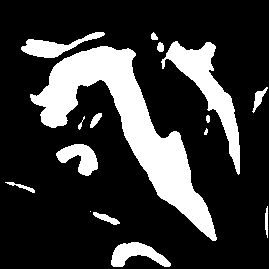

In [21]:
sub_masks['1']

In [13]:
type(sub_masks['1'])

PIL.Image.Image

In [14]:
np.array(sub_masks['1'])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# making patches

In [28]:
# [TODO] 최소 island area threshold 적용 필요
def create_multi_polygons(polygon, bufferNum, image_area, threshold=0.01):
    """Makes polygons cut off

    Args:
      polygon: A target polygon.
      bufferNum: A number of buffered polygon.
      image_area: A area of global image.
      threshold: A threshold.

    Returns:
      .: .

    Raises:
      .: .
    """

    buffered_polygon = polygon.buffer(bufferNum)
    if (type(buffered_polygon) == MultiPolygon):
        result = []
        for b_polygon in buffered_polygon:
            if b_polygon.area / image_area < threshold :
                result.append(b_polygon)
            else:
                result += create_multi_polygons(polygon, bufferNum-1, image_area, threshold)
        return result
    elif (type(buffered_polygon) == Polygon):
        if buffered_polygon.area / image_area < threshold :
            return [buffered_polygon]
        else :
            return create_multi_polygons(buffered_polygon, bufferNum-1, image_area, threshold)

In [35]:
# [TODO] 얻어낸 island 에서 IoU 기반으로한 patches 를 얻는 연산 필요 
def create_patches(sub_mask, color_image, img_width, img_height, 
                               filter_ratio=0.03, init_buffer=0):
    """Creates patches of semantic areas.

    Args:
      sub_mask: A sub mask image.
      color_image: A color image.
      img_width: .
      img_height: .
      filter_ratio: 
      init_buffer:

    Returns:
      .: .

    Raises:
      .: .
    """
                
#     img_width = sub_mask.width
#     img_height = sub_mask.height
#     print(img_width, img_height)
    image_area = img_width * img_height
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')
    
    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    patches = []
    fig = plt.figure()
    fig.set_size_inches(12, 27)
    for i, polygon in enumerate(multi_poly):
        area = polygon.area 
        ratio = area / image_area
        if ratio > filter_ratio : 
            buffered_polygons = create_multi_polygons(polygon, init_buffer, image_area)
            centroids = []
            for polyg in buffered_polygons:
                polyg = polyg.simplify(0.1, preserve_topology=False)
                if polyg.area == 0.0:
                    continue
                centroids.append(polyg.centroid.xy)
                drawPolygon(polyg, color_image)
            positions = []
            for ii in centroids:
                positions.append([ii[0][0], ii[1][0]])

            lines = []
            if (len(positions) > 1) : 
                for i in range(len(positions)):
                    if i == 0:
                        vector = []
                        for j in range(2):
                            vector.append(positions[i][j] - positions[i+1][j])
                        
                        d = (vector[1] / vector[0]) * (-positions[0][0]) + positions[0][1]
                        c = (vector[0] / vector[1]) * (-positions[0][1]) + positions[0][0]
                        
                        result = []
                        if abs(d) >= abs(c):
                            result.append(c)
                            result.append(0)
                        else:
                            result.append(0)
                            result.append(d)
                        la = LineString([result, positions[i]])
                        lines.append(la)
                        x,y = la.xy
                        plt.plot(x,y, linewidth=1)

                    elif i == len(positions)-1:
                        vector = []
                        for j in range(2):
                            vector.append(positions[i][j] - positions[i-1][j])
                        d = (vector[1] / vector[0]) * (img_width-positions[i][0]) + positions[i][1]
                        c = (vector[0] / vector[1]) * (img_height-positions[i][1]) + positions[i][0]

                        result = []

                        if abs(d-img_height) >= abs(c-img_width):
                            result.append(img_width)
                            result.append(d)
                        else:
                            result.append(c)
                            result.append(img_height)
                        la = LineString([result, positions[i]])
                        lines.append(la)
                        x,y = la.xy
                        plt.plot(x,y, linewidth=1)
                    
                    if (not len(positions)-1 == i):
                        la = LineString([positions[i], positions[i+1]])
                        lines.append(la)
                        x,y = la.xy
                        plt.plot(x,y, linewidth=1)
            

            kinds = []
            ratios = []
            for l in lines:
                
                p1, p2 = l.xy
                ratio = (p2[1] - p2[0]) / (p1[1] - p1[0])
                
                if len(ratios) == 0:
                    ratios.append(ratio)
                    kinds.append([l])
                    continue
                else:
                    previous = ratios[-1]
                    ratios.append(ratio)
                    diff = abs(previous - ratio)
                    if diff < 0.25:
                        kinds[-1].append(l)
                    else:
                        kinds.append([l])
            
            seglines = []
            for k in kinds:
                coords = []
                for linestring in k:
                    coords += list(co for co in linestring.coords)
                kline = LineString(coords)
                seglines.append(kline)
                x,y = kline.xy
                plt.plot(x,y, linewidth=1)
            
            dilateds = []
            for segline in seglines:
                dilated = segline.buffer(30)
                dilateds.append(dilated)
                x,y = dilated.exterior.xy
                plt.plot(x,y, linewidth=1)
                
            drawPolygon(polygon, color_image)
#             if dilateds:
#                 for dilated in dilateds:
#                     _d = polygon.intersection(dilated)
#                     x,y = _d.exterior.xy
#                     splitPolygon = _d.simplify(1.0, preserve_topology=False)
#                     plt.plot(x,y, linewidth=10)

#             else:

    return patches

[]

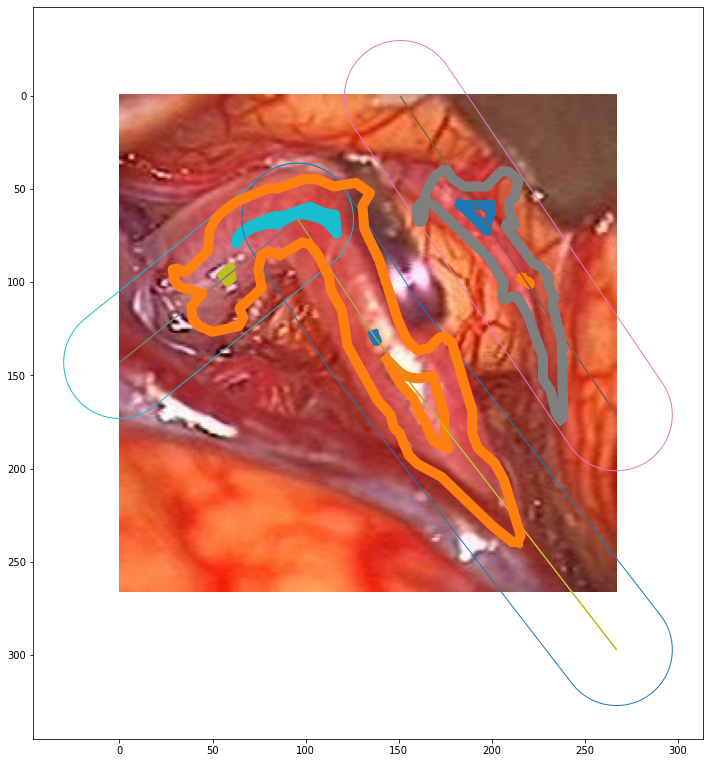

In [36]:
sub_masks, img_width, img_height = create_sub_masks(mask_images[0])
create_patches(np.array(sub_masks['1']), color_images[0], img_width, img_height)

[]

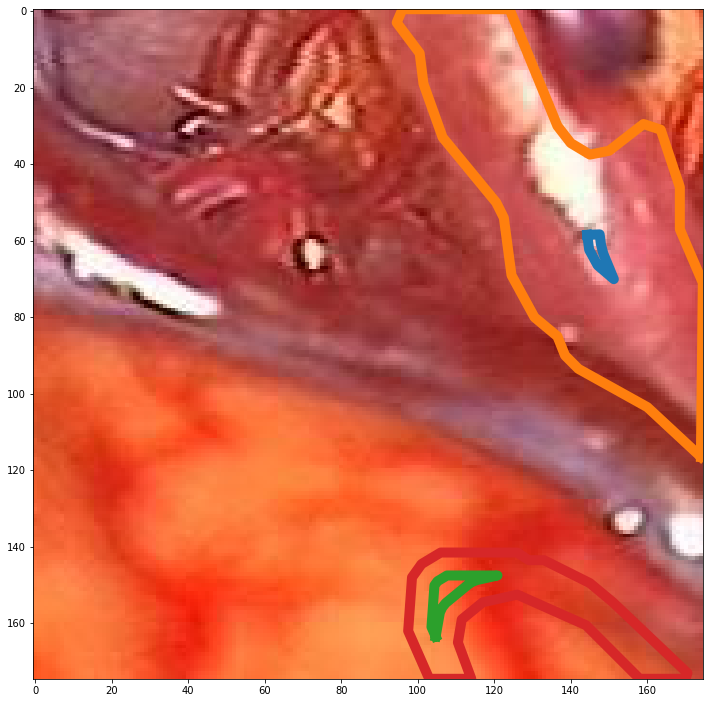

In [41]:
sub_masks, img_width, img_height = create_sub_masks(mask_images[1])
no_lines(np.array(sub_masks['1']), color_images[1], img_width, img_height)

[]

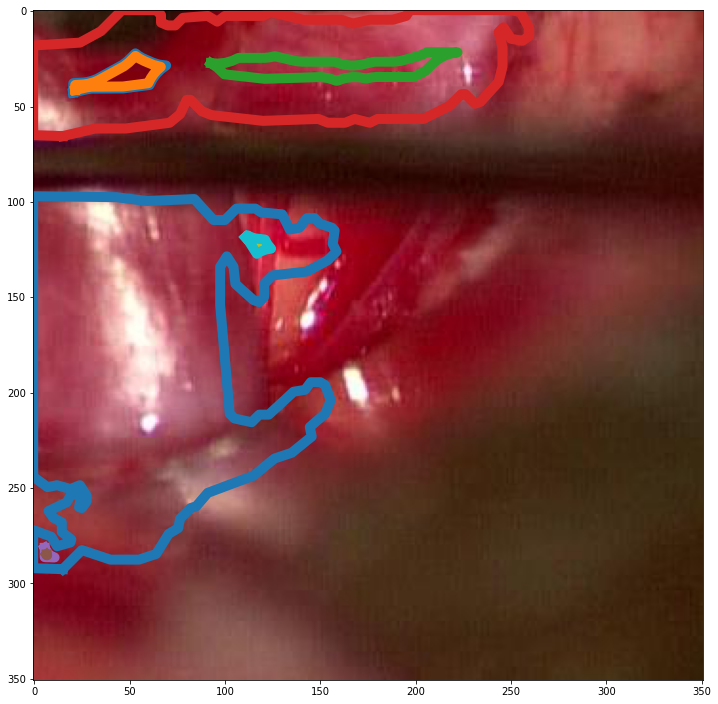

In [40]:
sub_masks, img_width, img_height = create_sub_masks(mask_images[2])
no_lines(np.array(sub_masks['1']), color_images[2], img_width, img_height)